In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))
from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Visualise clusters in data

The point of this notebook is to look at the distributions of some variables to see if they are as efficient to tell apart categories of signal/background as in the simulation.

In [2]:
from lib import plot as lp, rootdata as lrd, data

from project import defs, files, col

import itertools

## Load ROOT file

In [3]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean'
]

columns_to_compute = [
    'max_m_mean',
    'mean_m_pedestal',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red',
    'min_std_pos_neg_redpn',
]

new_columns = ['mean_before_end_peak', 'mean_after_end_peak', 'pos_first_neg_after_max']
columns_to_compute += ['mean_before_end_peak_red', 'mean_after_end_peak_red']

In [4]:
config_name = "SNP2"
file_path = files.get_path_processed_root(config_name)
dataframe = lrd.load_ROOT_into_dataframe(
    file_path,
    tree_name=defs.proc_tree_name,
    variables=columns_already_computed+defs.list_samples_columns,
    # cut="std!=0"
)


Time taken to load the ROOT files: 17.516446113586426
ROOT files loaded: /mnt/d/900GeV/processed/simulation/SNP2.root


In [5]:
dataframe = dataframe.query("std!=0")

In [6]:
files.compute_peak_voi(
    dataframe, zero_column="mean", red=True
) 

# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)

Time taken: 1.9888312816619873


### Cuts

In [7]:
dataframe_filtered = dataframe.query("pos_first_neg_after_max!=-1")
len_before, len_after = len(dataframe), len(dataframe_filtered)
print("Efficiency:", (len_before - len_after) / len_before)

Efficiency: 0.021428466617306383


### Checking plots

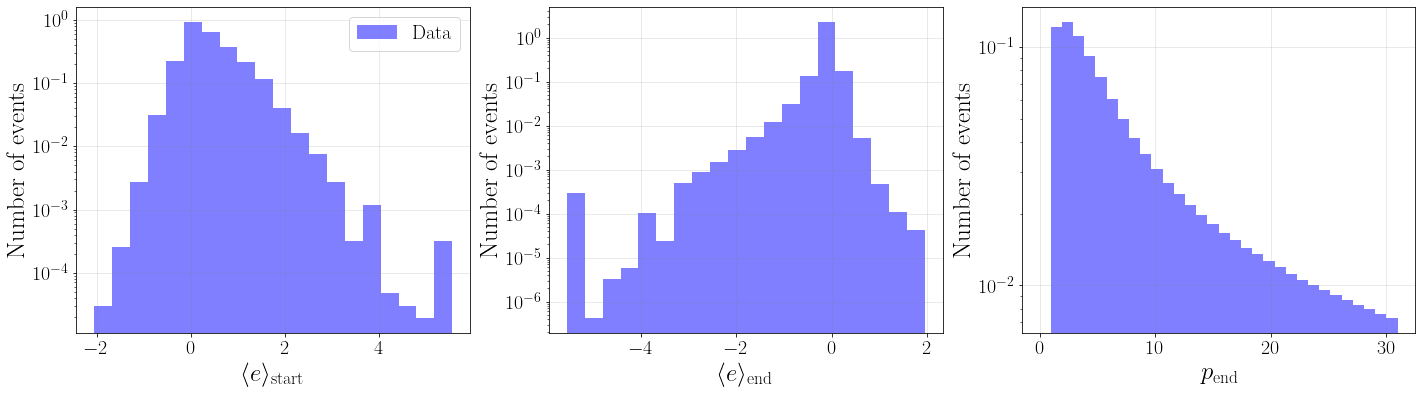

In [8]:
fig, axes = lp.multi_plot_hist(
    [dataframe_filtered], 
    new_columns, column_labels,
    list_colors=['b'],
    list_labels=['Data'],
    logscale=True,
    nbins={
        'default': 20,
        'pos_first_neg_after_max': 32,
        'p_end': 32
    },
    range_columns={
        'default': 20,
        'pos_first_neg_after_max': [0, 31],
        'p_end': [0, 31]
    }
)

## How to rapidly tell apart the peaked background from the noise + signal

(<Figure size 576x432 with 2 Axes>,
 <AxesSubplot:xlabel='$\\frac{\\min{\\left(\\sigma^{+}_e, \\sigma^{-}_e\\right)}}{\\sigma_{e}^{+} + \\sigma_{e}^{-}}$', ylabel='$\\max{e} - \\langle e \\rangle$'>)

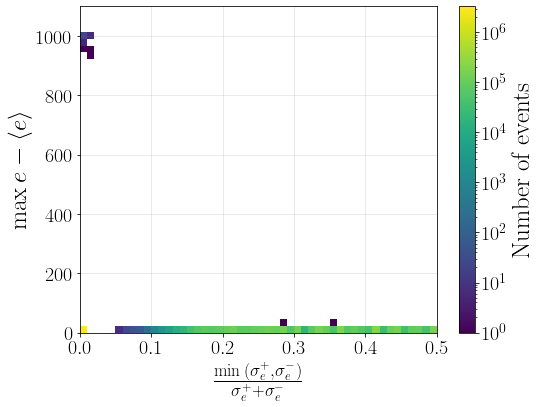

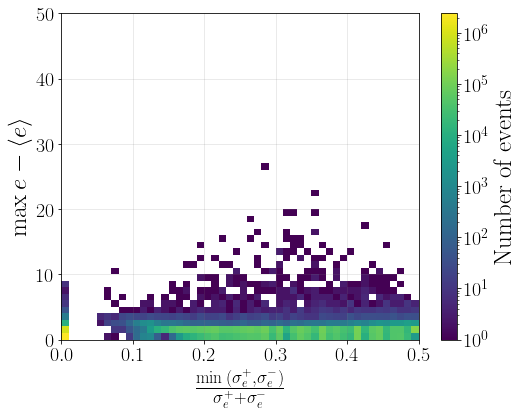

In [9]:
lp.plot_hist2d(
    dataframe['min_std_pos_neg_redpn'], dataframe['max_m_mean'],
    column_labels['min_std_pos_neg_redpn'], column_labels['max_m_mean'],
    logscale=True,
    min_max=[[0., .5], [0., 1100.]]
)

lp.plot_hist2d(
    dataframe['min_std_pos_neg_redpn'], dataframe['max_m_mean'],
    column_labels['min_std_pos_neg_redpn'], column_labels['max_m_mean'],
    logscale=True,
    min_max=[[0., .5], [0., 50.]]
)

**Description**
- Events with very small $\min(\sigma_+, \sigma_-)$ are peaked background.
- Events with small $\max{e} - e_0$ (or $\max{e} - \langle e \rangle$) is either noise or signal with va very low amplitude
- Events with higher $\max{e} - \langle e \rangle$ are signal events. Noise usually don't reach high amplitudes.

For practical reasons, it is consistent to the peaked background before applying a clustering algorithm.

## How to tell signal apart - are the variables we use consistent ?

We remove the peaked background in this section.

In [11]:
df_no_peak = dataframe_filtered.query("min_std_pos_neg_redpn > 0.02")

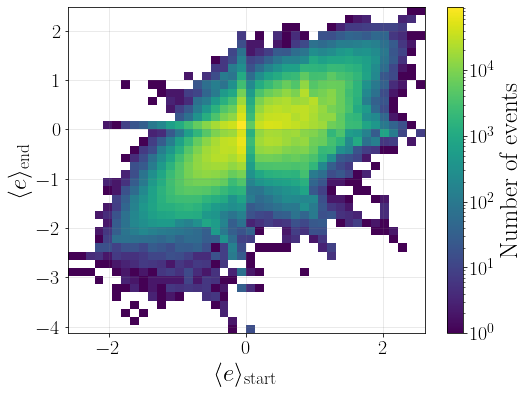

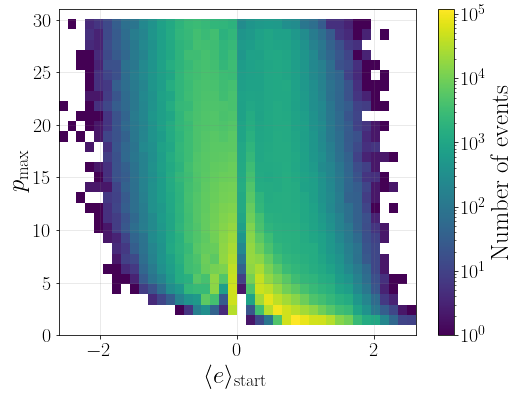

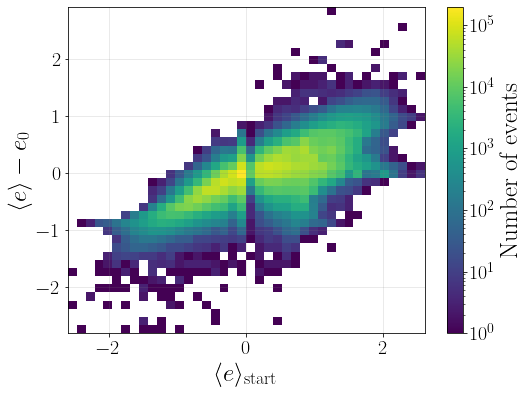

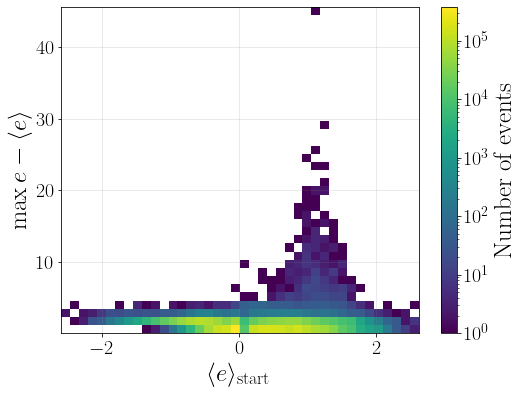

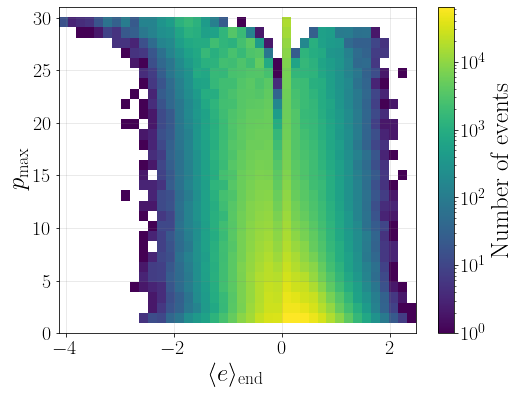

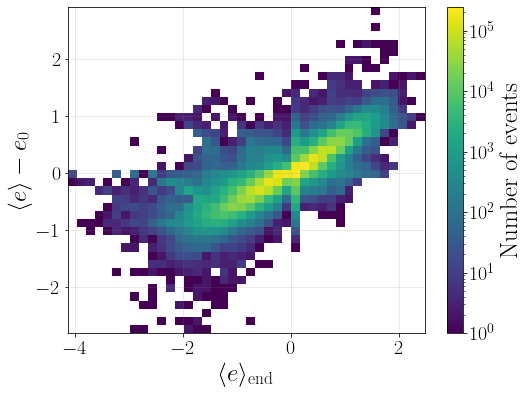

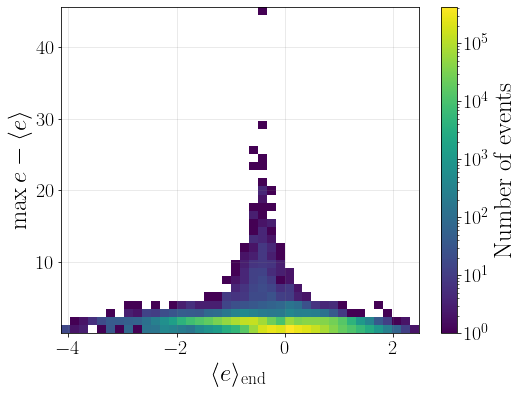

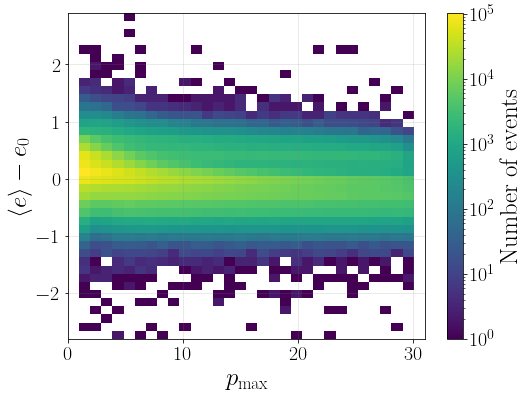

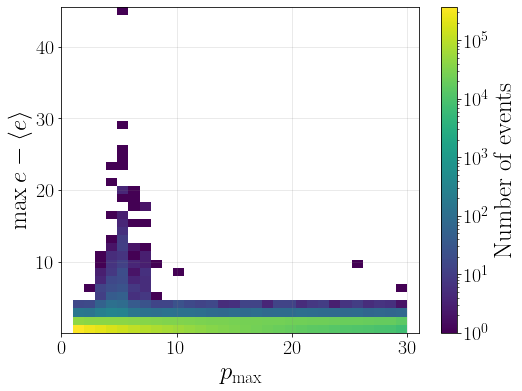

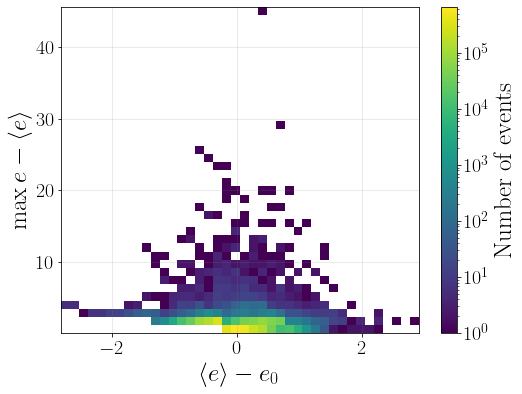

In [12]:
interesting_features = ["mean_before_end_peak", "mean_after_end_peak", "pos_max", "mean_m_pedestal", "max_m_mean"]

column_ranges = {
    "pos_max": [0, 31]
}
column_nbins = {
    "pos_max": 32,
    "default": 40
}

for name_var1, name_var2 in itertools.combinations(interesting_features, 2):
    min_max = [None, None]
    bins = [None, None]

    if name_var1 in column_ranges:
        min_max[0] = column_ranges[name_var1]
    if name_var2 in column_ranges:
        min_max[1] = column_ranges[name_var2]

    bins[0] = column_nbins.get(name_var1, column_nbins['default'])
    bins[1] = column_nbins.get(name_var2, column_nbins['default'])

    if bins==[None, None]:
        bins = None


    lp.plot_hist2d(
        df_no_peak[name_var1], df_no_peak[name_var2],
        column_labels[name_var1], column_labels[name_var2],
        logscale=True,
        min_max=min_max,
        bins=bins

    )

We see from the plots with $\max{e} - \langle e \rangle$ that high values (corresponding to signal) correspond to:
- $p_\text{max}$ usually below 10 
- $p_\text{max}$ usually below 10 
- $\langle e_\text{end} \rangle$ between -2 and 1. (can be positive !)
- $\langle e_\text{start} \rangle$ between 0 and 2

The variables that seem to be discriminative to find signal are:
- $p_\text{max}$ 
- $\langle e_\text{start} \rangle$
- $\langle e_\text{end} \rangle$

There is also funny behaviours around $\langle e_\text{end}\rangle = 0$ and  $\langle e_\text{start} \rangle = 0$ 

We can select obvious signal with the cut $\max{e} - \langle e \rangle > 5$ and see where the signal is.
This result can be compared to simulation.